In [1]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzf ta-lib-0.4.0-src.tar.gz
%cd ta-lib/
!./configure --prefix=/usr
!make
!make install
%cd ..
!pip install ta-lib


--2024-06-28 22:05:59--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-06-28 22:05:59--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://psychz.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2024-06-28 22:05:59--  http://psychz.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1
Resolving p

In [3]:
!pip install transformers

## Load the dataset and preprocess the dataframe in the required format.

Technical indicators created for the environment include:

- RSI
- MACD
- Stoch_k
- OBV
- Upper_BB
- ATR_1
- ATR_2
- ATR_5
- ATR_10
- ATR_20

In [2]:
import pandas as pd
import numpy as np
import talib as ta

class TechnicalIndicators:
    def __init__(self, data):
        self.data = data

    def add_momentum_indicators(self):
        """
        Add momentum indicators to the dataframe.
        """
        self.data['RSI'] = ta.RSI(self.data['Close'], timeperiod=14)
        self.data['MACD'], self.data['MACD_signal'], self.data['MACD_hist'] = ta.MACD(self.data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
        self.data['Stoch_k'], self.data['Stoch_d'] = ta.STOCH(self.data['High'], self.data['Low'], self.data['Close'],
                                                              fastk_period=14, slowk_period=3, slowd_period=3)

    def add_volume_indicators(self):
        self.data['OBV'] = ta.OBV(self.data['Close'], self.data['Volume'])

    def add_volatility_indicators(self):
        self.data['Upper_BB'], self.data['Middle_BB'], self.data['Lower_BB'] = ta.BBANDS(self.data['Close'], timeperiod=20)
        self.data['ATR_1'] = ta.ATR(self.data['High'], self.data['Low'], self.data['Close'], timeperiod=1)
        self.data['ATR_2'] = ta.ATR(self.data['High'], self.data['Low'], self.data['Close'], timeperiod=2)
        self.data['ATR_5'] = ta.ATR(self.data['High'], self.data['Low'], self.data['Close'], timeperiod=5)
        self.data['ATR_10'] = ta.ATR(self.data['High'], self.data['Low'], self.data['Close'], timeperiod=10)
        self.data['ATR_20'] = ta.ATR(self.data['High'], self.data['Low'], self.data['Close'], timeperiod=20)

    def add_trend_indicators(self):
        self.data['ADX'] = ta.ADX(self.data['High'], self.data['Low'], self.data['Close'], timeperiod=14)
        self.data['+DI'] = ta.PLUS_DI(self.data['High'], self.data['Low'], self.data['Close'], timeperiod=14)
        self.data['-DI'] = ta.MINUS_DI(self.data['High'], self.data['Low'], self.data['Close'], timeperiod=14)
        self.data['CCI'] = ta.CCI(self.data['High'], self.data['Low'], self.data['Close'], timeperiod=5)

    def add_other_indicators(self):
        self.data['DLR'] = np.log(self.data['Close'] / self.data['Close'].shift(1))
        self.data['TWAP'] = self.data['Close'].expanding().mean()
        self.data['VWAP'] = (self.data['Volume'] * (self.data['High'] + self.data['Low']) / 2).cumsum() / self.data['Volume'].cumsum()

    def add_all_indicators(self):
        self.add_momentum_indicators()
        self.add_volume_indicators()
        self.add_volatility_indicators()
        self.add_trend_indicators()
        self.add_other_indicators()
        return self.data

In [28]:
data = pd.read_csv('/content/xnas-itch-20230703.tbbo.csv')

# Preprocessing to create necessary columns
data['price']=data['price']/1e9
data['bid_px_00']=data['bid_px_00']/1e9
data['ask_px_00']=data['ask_px_00']/1e9

data['Close'] = data['price']
data['Volume'] = data['size']
data['High'] = data[['bid_px_00', 'ask_px_00']].max(axis=1)
data['Low'] = data[['bid_px_00', 'ask_px_00']].min(axis=1)
data['Open'] = data['Close'].shift(1).fillna(data['Close'])


# Dropping columns and mapping string to int

ti = TechnicalIndicators(data)
df_with_indicators = ti.add_all_indicators()
df_with_indicators = df_with_indicators.drop(['rtype', 'publisher_id', 'instrument_id', 'action', 'depth', 'sequence', 'symbol'], axis=1)
side_mapping = {
    'A': 0,
    'B': 1,
    'N': 2
}
df_with_indicators['side'] = df_with_indicators['side'].map(side_mapping).astype(int)


flag_mapping = {
    130: 1,
    128: 2,
    0: 0
}
df_with_indicators['flags'] = df_with_indicators['flags'].map(flag_mapping)




market_features_df = df_with_indicators[35:]
# market_features_df.to_csv('market_features_df.csv', index=False)


Checking the dataset:

In [34]:
# Show all columns in pandas
pd.set_option('display.max_columns', None)
market_features_df.head(35)

# market_features_df.shape


,ts_recv,ts_event,side,price,size,flags,ts_in_delta,bid_px_00,ask_px_00,bid_sz_00,ask_sz_00,bid_ct_00,ask_ct_00,Close,Volume,High,Low,Open,RSI,MACD,MACD_signal,MACD_hist,Stoch_k,Stoch_d,OBV,Upper_BB,Middle_BB,Lower_BB,ATR_1,ATR_2,ATR_5,ATR_10,ATR_20,ADX,+DI,-DI,CCI,DLR,TWAP,VWAP
0,1688371214386057385,1688371214385893078,2,194.05,50,1,164307,194.00,194.30,3101,19,4,10,194.05,50,194.30,194.00,194.05,54.544543,0.006271,-0.003130,0.009401,5.252525e+01,61.952862,-266.0,194.065621,194.0170,193.968379,0.30,0.175078,0.098615,0.075141,0.072403,97.257397,30.435801,0.196362,166.666667,0.000000,194.020000,194.021894
1,1688371214386063777,1688371214385899379,2,194.05,50,1,164398,194.00,194.30,3101,19,4,10,194.05,50,194.30,194.00,194.05,54.544543,0.007108,-0.001082,0.008190,3.838384e+01,52.525253,-266.0,194.068990,194.0200,193.971010,0.30,0.237539,0.138892,0.097627,0.083783,97.361721,22.989295,0.148320,83.333333,0.000000,194.020811,194.025188
2,1688371215804852019,1688371215804687301,1,194.21,10,1,164718,194.00,194.21,3101,29,4,1,194.21,10,194.21,194.00,194.05,85.890753,0.020446,0.003223,0.017223,4.040404e+01,43.771044,-256.0,194.125889,194.0305,193.935111,0.21,0.223770,0.153114,0.108864,0.090094,97.458593,19.409454,0.125224,79.268293,0.000824,194.025789,194.025596
3,1688371219671476629,1688371219671312224,2,194.14,10,1,164405,194.00,194.16,3101,400,4,1,194.14,10,194.16,194.00,194.21,64.827662,0.025079,0.007594,0.017484,4.949495e+01,42.760943,-266.0,194.142928,194.0375,193.932072,0.21,0.216885,0.164491,0.118978,0.096089,97.548546,16.622008,0.107240,-3.205128,-0.000360,194.028718,194.025873
4,1688371223368835585,1688371223368671235,1,194.13,10,1,164350,194.00,194.13,3101,400,4,1,194.13,10,194.13,194.00,194.14,62.470772,0.027625,0.011601,0.016025,5.757576e+01,49.158249,-276.0,194.155247,194.0440,193.932753,0.14,0.178442,0.159593,0.121080,0.098285,97.632074,15.068361,0.097216,-113.095238,-0.000052,194.031250,194.026071
5,1688371229849940201,1688371229849775570,1,194.13,100,1,164631,194.01,194.13,101,390,2,1,194.13,100,194.13,194.01,194.13,62.470772,0.029305,0.015141,0.014164,4.949495e+01,52.188552,-276.0,194.165821,194.0505,193.935179,0.12,0.149221,0.151674,0.120972,0.099370,97.709636,13.871534,0.089495,-64.102564,0.000000,194.033659,194.028188
6,1688371230451172473,1688371230451005195,2,194.02,10,0,167278,194.01,194.16,101,400,2,1,194.02,10,194.16,194.01,194.13,42.676806,0.021513,0.016416,0.005097,3.454545e+01,47.205387,-286.0,194.165390,194.0515,193.937610,0.15,0.149611,0.151339,0.123875,0.101902,97.793820,14.463498,0.080850,-113.425926,-0.000567,194.033333,194.028460
7,1688371230451172473,1688371230451005195,0,194.01,1,0,167278,194.01,194.16,101,400,2,1,194.01,1,194.16,194.01,194.02,41.392784,0.014365,0.016006,-0.001641,1.949495e+01,34.511785,-287.0,194.165066,194.0520,193.938934,0.15,0.149805,0.151071,0.126487,0.104307,97.871992,13.100725,0.073232,-90.909091,-0.000052,194.032791,194.028488
8,1688371230451172473,1688371230451005195,0,194.01,100,1,167278,194.01,194.16,100,400,1,1,194.01,100,194.16,194.01,194.01,41.392784,0.008601,0.014525,-0.005924,4.444444e+00,19.494949,-287.0,194.164727,194.0525,193.940273,0.15,0.149903,0.150857,0.128839,0.106591,97.944580,11.893862,0.066486,-61.224490,0.000000,194.032273,194.031073
9,1688371230451995982,1688371230451829005,0,194.00,3075,0,166977,194.00,194.16,3119,400,5,1,194.00,3075,194.16,194.00,194.01,39.997126,0.003189,0.012257,-0.009069,2.222222e+00,8.720539,-3362.0,194.164727,194.0525,193.940273,0.16,0.154951,0.152686,0.131955,0.109262,97.267563,10.755675,0.658220,-81.081081,-0.000052,194.031556,194.059670


In [35]:
market_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59236 entries, 0 to 59235
Data columns (total 40 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ts_recv      59236 non-null  int64  
 1   ts_event     59236 non-null  int64  
 2   side         59236 non-null  int64  
 3   price        59236 non-null  float64
 4   size         59236 non-null  int64  
 5   flags        59236 non-null  int64  
 6   ts_in_delta  59236 non-null  int64  
 7   bid_px_00    59236 non-null  float64
 8   ask_px_00    59236 non-null  float64
 9   bid_sz_00    59236 non-null  int64  
 10  ask_sz_00    59236 non-null  int64  
 11  bid_ct_00    59236 non-null  int64  
 12  ask_ct_00    59236 non-null  int64  
 13  Close        59236 non-null  float64
 14  Volume       59236 non-null  int64  
 15  High         59236 non-null  float64
 16  Low          59236 non-null  float64
 17  Open         59236 non-null  float64
 18  RSI          59236 non-null  float64
 19  MACD

In [37]:
# Including signals in market_features_df from the provided trade blotter csv

# Load the datasets
trades_blotter_path = '/content/trades_blotter.csv'
market_features_df_path = '/content/market_features_df.csv'

trades_blotter = pd.read_csv(trades_blotter_path)
market_features_df = pd.read_csv(market_features_df_path)

print("Trades Blotter shape:")
print(trades_blotter.shape)


print("\nMain Data shape:")
print(market_features_df.shape)


action_df = trades_blotter[['action']] #extracting signals from trade blotter

merged_data = pd.concat([market_features_df, action_df], axis=1)

print("\nMerged Data shape:")
print(merged_data.shape)
print("Merged Data:")
print(merged_data.head())

# merged_data.to_csv('merged_data.csv', index=False)


Trades Blotter shape:
(59236, 11)

Main Data shape:
(59236, 40)

Merged Data shape:
(59236, 41)
Merged Data:
               ts_recv             ts_event  side   price  size  flags  \
0  1688371214386057385  1688371214385893078     2  194.05    50      1   
1  1688371214386063777  1688371214385899379     2  194.05    50      1   
2  1688371215804852019  1688371215804687301     1  194.21    10      1   
3  1688371219671476629  1688371219671312224     2  194.14    10      1   
4  1688371223368835585  1688371223368671235     1  194.13    10      1   

   ts_in_delta  bid_px_00  ask_px_00  bid_sz_00  ask_sz_00  bid_ct_00  \
0       164307      194.0     194.30       3101         19          4   
1       164398      194.0     194.30       3101         19          4   
2       164718      194.0     194.21       3101         29          4   
3       164405      194.0     194.16       3101        400          4   
4       164350      194.0     194.13       3101        400          4   

   ask_

## Preparing data for transformer

In [62]:
df_with_indicators = pd.read_csv('/content/merged_data.csv')

# Apply the mapping to the target variable
action_mapping = {
    'BUY': 1,
    'HOLD': 0,
    'SELL': 2
}
df_with_indicators['action'] = df_with_indicators['action'].map(action_mapping).astype(int)

df_with_indicators = df_with_indicators.dropna()

### normalisation and creation of Tensors

In [63]:
X = df_with_indicators.drop('action', axis=1)
X = X.to_numpy().astype(np.float32)
print("X shape:")
print(X.shape)

# target variable
y = df_with_indicators['action'].to_numpy().astype(np.int64)



X shape:
(59236, 40)


In [64]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import torch

X_training, X_valid, y_train, y_vali = train_test_split(X, y, test_size=0.3, random_state=42)
X_testing, X_vali, y_test, y_val = train_test_split(X_valid, y_vali, test_size=0.5, random_state=42)

# normalization
scaler = StandardScaler()

X_train = scaler.fit_transform(X_training)
X_val = scaler.fit_transform(X_vali)
X_test = scaler.fit_transform(X_testing)

# adding sequence length dimension
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


# converion to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)



train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

## Transformer Model

### Model architecture

In [65]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel, BertConfig


class CustomTransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CustomTransformerModel, self).__init__()
        num_attention_heads = 40
        hidden_size = input_dim

        self.config = BertConfig(
            vocab_size=30522,
            hidden_size=hidden_size,
            num_hidden_layers=4,
            num_attention_heads=num_attention_heads,
            intermediate_size=4 * hidden_size,
        )
        self.bert = BertModel(self.config)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # x shape: [batch_size, seq_length, feature_dim]
        outputs = self.bert(inputs_embeds=x)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        x = F.relu(self.fc1(pooled_output))
        x = self.dropout(x)
        return self.fc2(x)



### Training

In [71]:
import time
from transformers import AdamW, get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from torch.optim.lr_scheduler import ReduceLROnPlateau


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, optimizer, and scheduler
model = CustomTransformerModel(input_dim=X_train.shape[2], output_dim=3)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Early stopping parameters
patience = 7
best_val_loss = float('inf')
epochs_no_improve = 0

num_epochs = 100

train_losses = []
val_losses = []
epoch_times = []


# Training loop
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    epoch_train_loss = 0

    for batch_data, batch_labels in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_train_loss / len(train_loader)}')

    # Validation
    model.eval()
    epoch_val_loss = 0

    with torch.no_grad():
        for batch_data, batch_labels in val_loader:
            val_outputs = model(batch_data)
            val_loss = criterion(val_outputs, batch_labels)
            epoch_val_loss += val_loss.item()

    val_losses.append(epoch_val_loss / len(val_loader))
    scheduler.step(epoch_val_loss / len(val_loader))
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {epoch_val_loss / len(val_loader)}')


    epoch_time = time.time() - start_time
    epoch_times.append(epoch_time)

    # Check for early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'model.pt')
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        break

# Load the model
model.load_state_dict(torch.load('model.pt'))

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Training Loss: 0.5079490105954954
Epoch 1/100, Validation Loss: 0.4854056672226611
Epoch 2/100, Training Loss: 0.43629707612189245
Epoch 2/100, Validation Loss: 0.46284808164877855
Epoch 3/100, Training Loss: 0.42760505616940836
Epoch 3/100, Validation Loss: 0.4609523825079417
Epoch 4/100, Training Loss: 0.4178317474362291
Epoch 4/100, Validation Loss: 0.4560624041574464
Epoch 5/100, Training Loss: 0.4138652864429686
Epoch 5/100, Validation Loss: 0.43832136272526473
Epoch 6/100, Training Loss: 0.40343939211725455
Epoch 6/100, Validation Loss: 0.4232832028282632
Epoch 7/100, Training Loss: 0.40217287098000076
Epoch 7/100, Validation Loss: 0.4248107088555535
Epoch 8/100, Training Loss: 0.3998963442389612
Epoch 8/100, Validation Loss: 0.42025144516135293
Epoch 9/100, Training Loss: 0.39259682565835524
Epoch 9/100, Validation Loss: 0.4172499424262012
Epoch 10/100, Training Loss: 0.38968175930189497
Epoch 10/100, Validation Loss: 0.4045899946698182
Epoch 11/100, Training Loss: 

<All keys matched successfully>

### Testing

In [82]:
# Generate trading signals using the transformer model
def generate_signals(model, data):
    model.eval()
    with torch.no_grad():
        outputs = model(torch.tensor(data, dtype=torch.float32))
        _, predicted = torch.max(outputs, 1)
    return predicted.numpy()

signals = generate_signals(model, X_test)

# Compare predictions with true labels
accuracy = (signals == y_test).mean()
print(f'Test Accuracy : {accuracy * 100:.2f}%')

# Print some sample predictions
print("Sample Predictions:")
for i in range(10):
    print(f'True: {y_test[i]}, Predicted: {signals[i]}')

Test Accuracy : 84.99%
Sample Predictions:
True: 2, Predicted: 0
True: 0, Predicted: 0
True: 0, Predicted: 0
True: 1, Predicted: 1
True: 0, Predicted: 0
True: 2, Predicted: 2
True: 1, Predicted: 1
True: 1, Predicted: 1
True: 0, Predicted: 0
True: 2, Predicted: 0


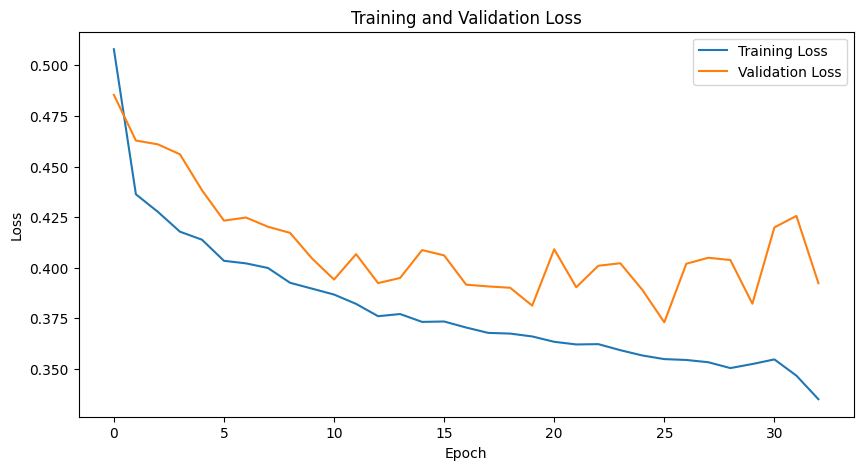

In [73]:
# Loss vs epochs
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Classification Report:
              precision    recall  f1-score   support

         Buy       0.86      0.79      0.82      3941
        Hold       0.81      0.93      0.87      2548
        Sell       0.88      0.86      0.87      2396

    accuracy                           0.85      8885
   macro avg       0.85      0.86      0.85      8885
weighted avg       0.85      0.85      0.85      8885



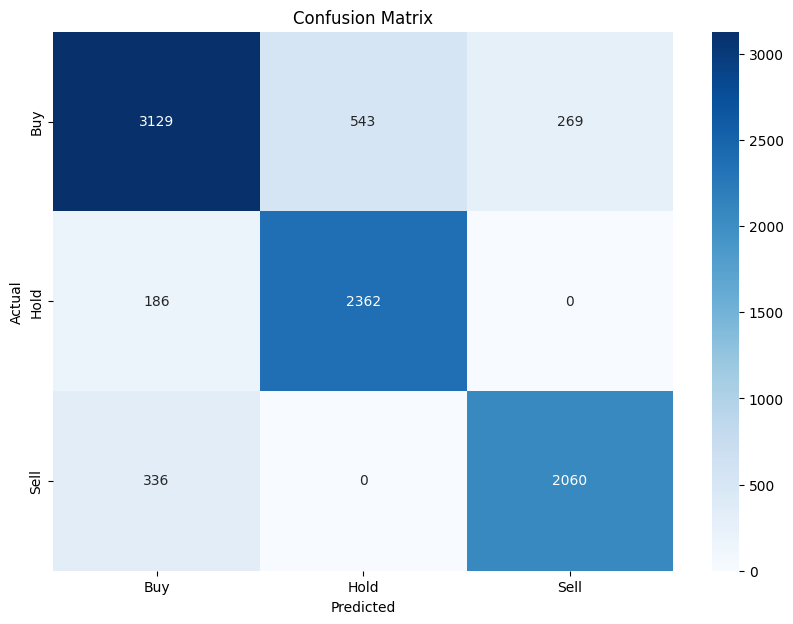

In [75]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

print("Classification Report:")
print(classification_report(y_test, signals, target_names=['Buy', 'Hold','Sell']))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, signals)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Buy', 'Hold','Sell'], yticklabels=['Buy', 'Hold','Sell'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Evaluation in Trade Blotter

In [76]:
signals = generate_signals(model, X_test)

# Map the signals to trade actions
signal_mapping = {0: 'HOLD', 1: 'BUY', 2: 'SELL'}
trade_actions = [signal_mapping[signal] for signal in signals]


states = df_with_indicators.drop('action', axis=1).columns.tolist()

# Add the trade actions to the test data for evaluation

test_data_with_signals = pd.DataFrame(X_testing.squeeze(), columns=states)
test_data_with_signals['trade_action'] = trade_actions
test_data_with_signals['symbol'] = 'AAPL'

In [77]:
test_data_with_signals.shape

(8885, 42)

In [78]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

INITIAL_CASH = 10_000_000  # $10 million

def preprocess_data(df):
    df['liquidity'] = df['bid_sz_00'] * df['bid_px_00'] + df['ask_sz_00'] * df['ask_px_00']
    return df

def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_vol_and_liquidity(price_df, volume_df, window_size):
    # Calculate rolling statistics
    rolling_mean_vol = price_df.pct_change().rolling(window=window_size).mean()
    rolling_std_vol = price_df.pct_change().rolling(window=window_size).std()
    rolling_mean_liq = volume_df.rolling(window=window_size).mean()
    rolling_std_liq = volume_df.rolling(window=window_size).std()

    return rolling_mean_vol, rolling_std_vol, rolling_mean_liq, rolling_std_liq

def get_percentile(current_value, mean, std):
    if std > 0:
        z_score = (current_value - mean) / std
        percentile = norm.cdf(z_score)
    else:
        percentile = 0.5  # No variation
    return percentile

def get_trade_price(base_price, current_vol, current_liq, mean_vol, std_vol, mean_liq, std_liq, trade_direction):
    vol_percentile = get_percentile(current_vol, mean_vol, std_vol)
    liq_percentile = get_percentile(current_liq, mean_liq, std_liq)

    # Define price adjustment scenarios based on market conditions
    if vol_percentile >= 0.9 and liq_percentile < 0.1:
        price_adjustment_percent = np.random.uniform(-0.25, -0.15)
    elif vol_percentile <= 0.1 and liq_percentile < 0.1:
        price_adjustment_percent = np.random.uniform(-0.10, -0.05)
    elif vol_percentile >= 0.9 and liq_percentile >= 0.9:
        price_adjustment_percent = np.random.uniform(-0.05, +0.10)
    else:
        price_adjustment_percent = np.random.uniform(-0.05, +0.05)  # Default for normal conditions

    # Adjust price based on trade direction
    if trade_direction == 'BUY':
        adjusted_price = base_price * (1 - price_adjustment_percent)
    else:  # SELL
        adjusted_price = base_price * (1 + price_adjustment_percent)

    return adjusted_price


In [86]:
class TradingEnvironmentwithBlotter:
    def __init__(self, data, signals, daily_trading_limit, window_size):
        self.data = preprocess_data(data)
        self.signals = signals
        self.daily_trading_limit = daily_trading_limit
        # self.INITIAL_CASH = 10000
        self.window_size = window_size
        self.state_columns = ['price', 'liquidity', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'Stoch_k', 'Stoch_d',
                              'OBV', 'Upper_BB', 'Middle_BB', 'Lower_BB', 'ATR_1', 'ADX', '+DI', '-DI', 'CCI']
        self.reset()

    def reset(self):
        self.current_step = 0
        self.balance = INITIAL_CASH
        self.shares_held = 0
        self.total_shares_traded = 0
        self.cumulative_reward = 0
        self.trades = []
        self.portfolio = {'cash': self.balance, 'holdings': {ticker: 0 for ticker in self.data['symbol'].unique()}}
        self.data['RSI'] = calculate_rsi(self.data['price'])
        self.data['pct_change'] = self.data['price'].pct_change()
        self.data['rolling_mean_vol'], self.data['rolling_std_vol'], self.data['rolling_mean_liq'], self.data['rolling_std_liq'] = calculate_vol_and_liquidity(self.data['price'], self.data['liquidity'], self.window_size)

    def step(self):
        # if self.current_step >= len(self.data):
        #     return

        row = self.data.iloc[self.current_step]
        current_price = row['price']
        current_time = pd.to_datetime(row['ts_event'])
        current_rsi = row['RSI']
        current_vol = row['pct_change']
        current_liq = row['liquidity']
        mean_vol = row['rolling_mean_vol']
        std_vol = row['rolling_std_vol']
        mean_liq = row['rolling_mean_liq']
        std_liq = row['rolling_std_liq']

        trade_action = self.signals[self.current_step]

        print(f"Step: {self.current_step}, Trade Action: {trade_action}, RSI: {current_rsi}, Price: {current_price}")

        trade_direction = 'HOLD'
        trade_size = 0
        trade_price = current_price

        if trade_action == 1:
            trade_direction = 'BUY'
            trade_price = get_trade_price(current_price, current_vol, current_liq, mean_vol, std_vol, mean_liq, std_liq, trade_direction)
            trade_size = (self.portfolio['cash'] * np.random.uniform(0.001, 0.005)) / trade_price
            if self.portfolio['cash'] >= trade_size * trade_price:
                self.portfolio['cash'] -= trade_size * trade_price
                self.portfolio['holdings'][row['symbol']] += trade_size
                print(f"BUY: Executed trade. Trade size: {trade_size}, Trade price: {trade_price}")
            else:
                trade_size = 0
                print("Insufficient cash for BUY trade")
        elif trade_action == 2:
            trade_direction = 'SELL'
            if self.portfolio['holdings'][row['symbol']] > 0:
                trade_size = min(self.portfolio['holdings'][row['symbol']], self.portfolio['cash'] * np.random.uniform(0.001, 0.005) / current_price)
                trade_price = get_trade_price(current_price, current_vol, current_liq, mean_vol, std_vol, mean_liq, std_liq, trade_direction)
                self.portfolio['cash'] += trade_size * trade_price
                self.portfolio['holdings'][row['symbol']] -= trade_size
                print(f"SELL: Executed trade. Trade size: {trade_size}, Trade price: {trade_price}")
            else:
                trade_size = 0
                print("No holdings to SELL")
        else:

            print("No trade executed")

        if trade_size > 0:
            expected_price = row['ask_px_00']
            actual_price = row['price']
            transaction_time = row['ts_in_delta']
            transaction_cost = self._calculate_transaction_cost(row['Volume'], 0.3, self.data['Volume'].mean())
            slippage = expected_price - actual_price
            time_penalty = 1000 * transaction_time / 1e9
            reward = - (slippage + time_penalty + transaction_cost)

            self.cumulative_reward += reward
            portfolio_value = self.portfolio['cash'] + self.portfolio['holdings'][row['symbol']] * row['price']
            print(f"Step: {self.current_step}, Portfolio Value: {portfolio_value}, Trade Direction: {trade_direction}, Trade Size: {trade_size}")

            self.trades.append({
                'step': self.current_step,
                'timestamp': current_time,
                'action': trade_direction,
                'price': trade_price,
                'shares': trade_size,
                'symbol': row['symbol'],
                'reward': reward,
                'transaction_cost': transaction_cost,
                'slippage': slippage,
                'time_penalty': time_penalty,
                'portfolio_value': portfolio_value
            })

        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            done=True
            self.current_step = 0

    def _calculate_transaction_cost(self, volume, volatility, daily_volume):
        return volatility * np.sqrt(volume / daily_volume)

    def run(self):
        self.reset()
        for _ in range(len(self.data)):
            self.step()
        return self.cumulative_reward, self.trades

    def render(self):

        trades_df = pd.DataFrame(self.trades)
        trades_df.to_csv('trades_blotter.csv', index=False)
        for trade in self.trades:
            print(f"Step: {trade['step']}, Timestamp: {trade['timestamp']}, Action: {trade['action']}, Price: {trade['price']}, Shares: {trade['shares']}, Symbol: {trade['symbol']}, Reward: {trade['reward']}, Transaction Cost: {trade['transaction_cost']}, Slippage: {trade['slippage']}, Time Penalty: {trade['time_penalty']}")

        print(f'Cumulative reward: {self.cumulative_reward}')
        if self.current_step < len(self.data):
            row = self.data.iloc[self.current_step]
            portfolio_value = self.portfolio['cash'] + self.portfolio['holdings'][row['symbol']] * row['Close']
            print(f'Total portfolio value: {portfolio_value}')
        else:
            print('No more data to process.')



In [87]:
# Run the trading environment with the generated signals
env_with_signals = TradingEnvironmentwithBlotter(test_data_with_signals, signals, daily_trading_limit=1000, window_size=60)
cumulative_reward, trades = env_with_signals.run()

# Render the results
env_with_signals.render()

df = pd.DataFrame(trades)

Streaming output truncated to the last 5000 lines.
Step: 414, Timestamp: 2023-07-03 14:21:52.694222848, Action: SELL, Price: 193.99133081281641, Shares: 117.02146950795976, Symbol: AAPL, Reward: -0.3277582206287384, Transaction Cost: 0.1381097137928009, Slippage: 0.0099945068359375, Time Penalty: 0.179654
Step: 415, Timestamp: 2023-07-03 15:30:35.862827008, Action: SELL, Price: 193.34487829849735, Shares: 66.30034662791533, Symbol: AAPL, Reward: -0.28652325131607054, Transaction Cost: 0.12040125131607055, Slippage: 0.0, Time Penalty: 0.166122
Step: 421, Timestamp: 2023-07-03 14:44:47.083757568, Action: BUY, Price: 183.59405553971365, Shares: 168.07534059645715, Symbol: AAPL, Reward: -0.3374661160049438, Transaction Cost: 0.15947535037994384, Slippage: 0.010009765625, Time Penalty: 0.167981
Step: 422, Timestamp: 2023-07-03 15:35:10.740733952, Action: BUY, Price: 200.3253034874459, Shares: 50.483112283586124, Symbol: AAPL, Reward: -0.33508685721588133, Transaction Cost: 0.159475350379943

In [88]:
# Calculate Risk Metrics, Trade Distribution, and Transaction Costs

def calculate_max_drawdown(portfolio_values):
    roll_max = portfolio_values.cummax()
    daily_drawdown = portfolio_values / roll_max - 1.0
    max_drawdown = daily_drawdown.cummin().min()
    return max_drawdown

def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)

if not df.empty:
    portfolio_values = df['portfolio_value']
    returns = portfolio_values.pct_change().dropna()

    max_drawdown = calculate_max_drawdown(portfolio_values)
    sharpe_ratio = calculate_sharpe_ratio(returns)
    volatility = np.std(returns)

    print(f'Maximum Drawdown: {max_drawdown:.2%}')
    print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
    print(f'Volatility: {volatility:.2%}')

    # Trade Distribution
    trade_distribution = df['action'].value_counts()
    print('Trade Distribution:')
    print(trade_distribution)

    buy_trades = df[df['action'] == 'BUY']
    sell_trades = df[df['action'] == 'SELL']
    hold_trades = df[df['action'] == 'HOLD']

    buy_outcome = buy_trades['reward'].sum()
    sell_outcome = sell_trades['reward'].sum()
    hold_outcome = hold_trades['reward'].sum()

    print(f'Buy Outcome: {buy_outcome:.2f}')
    print(f'Sell Outcome: {sell_outcome:.2f}')
    print(f'Hold Outcome: {hold_outcome:.2f}')

    # Transaction Costs
    total_transaction_cost = df['transaction_cost'].sum()
    total_slippage = df['slippage'].sum()
    total_time_penalty = df['time_penalty'].sum()

    print(f'Total Transaction Cost: {total_transaction_cost:.2f}')
    print(f'Total Slippage: {total_slippage:.2f}')
    print(f'Total Time Penalty: {total_time_penalty:.2f}')

    # Final Portfolio Value
    final_portfolio_value = portfolio_values.iloc[-1]
    print(f'Final Portfolio Value: {final_portfolio_value:.2f}')


else:
    print("No trades were recorded.")

Maximum Drawdown: -0.97%
Sharpe Ratio: 0.00
Volatility: 0.21%
Trade Distribution:
action
BUY     2904
SELL    2329
Name: count, dtype: int64
Buy Outcome: -855.27
Sell Outcome: -696.32
Hold Outcome: 0.00
Total Transaction Cost: 620.32
Total Slippage: 44.76
Total Time Penalty: 886.51
Final Portfolio Value: 9993342.73
